### Mount Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

### Import Libraries

In [0]:
from tqdm import tqdm
import glob
import os 
import string
from pathlib import Path
import cv2
import time
import copy
import sys
import pandas as pd
from sklearn.model_selection import train_test_split

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset,random_split
from torchvision import transforms
import torchvision
from torchvision.models import resnet18
import matplotlib.pyplot as plt

import albumentations as A
from albumentations import (CLAHE,HueSaturationValue, Normalize, Resize, Compose, GaussNoise,RandomBrightness,RandomGamma,RandomContrast)
from albumentations.pytorch import ToTensor
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [0]:
import math
from torch.nn import DataParallel

In [0]:
%matplotlib inline
plt.style.use('seaborn')

### Helper Functions

In [0]:
class strLabelConverter(object):
    """Convert between str and label.
        Insert `blank` to the alphabet for CTC.
    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet: str, ignore_case: bool = True):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.char2idx = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.char2idx[char] = i + 1
        self.idx2char = {idx: char for char, idx in self.char2idx.items()}

    def encode(self, text):
        """Support batch or single str.
        Args:
            text (str or list of str): texts to convert.
        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        if isinstance(text, str):
            text = [
                self.char2idx[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.
        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        Raises:
            AssertionError: when the texts and its length does not match.
        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
        return texts

In [0]:
def decode_prediction(logits: torch.Tensor,
                      label_converter: strLabelConverter) -> str:
    tokens = logits.softmax(2).argmax(2)
    tokens = tokens.squeeze(1).numpy()

    # convert tor stings tokens
    tokens = ''.join([label_converter.idx2char[token]
                      if token != 0 else '-'
                      for token in tokens])
    # print("tokens:",tokens)
    tokens = tokens.split('-')
    # remove duplicates    

    text = []
    for batch_token in tokens:
      for idx, char in enumerate(batch_token):
        if len(batch_token) > 1 and idx == 0:
          text.append(char)
        elif idx > 1 and len(batch_token) > 1 and char != batch_token[idx - 1]:
          text.append(char)
        elif len(batch_token) == 1:
          text.append(char)
        else:
          pass


    text = ''.join(text)
    return text

In [0]:
def print_prediction(model, dataset, device, label_converter):
    idx = np.random.randint(len(dataset))

    with torch.no_grad():
        model.eval()
        img, target_text = dataset[idx]
        img = img.unsqueeze(0)
        logits = model(img.to(device))
        # print("Logits:",logits.cpu()[0])

    pred_text = decode_prediction(logits.cpu(), label_converter)

    path = dataset.file_path
    img = np.asarray(Image.open(path).convert('L'))
    print("Truth:", target_text)
    print("Prediction:", pred_text)
    print()
    plt.imshow(img)
    plt.axis('off')

In [0]:
def acc_calc(model, dataset, label_converter) -> float:
    acc = 0
    with torch.no_grad():
        model.eval()
        for idx in range(len(dataset)):
            img, text = dataset[idx]
            logits = model(img.unsqueeze(0).to(device))
            pred_text = decode_prediction(logits.cpu(), label_converter)
            
            if pred_text == text:
                acc += 1
            
    return acc / len(dataset) * 100

In [0]:
hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]

hindi_alphabets_str = "".join(hindi_alphabets)
label_converter = strLabelConverter(hindi_alphabets_str)

'ऀँंःऄअआइईउऊऋऌऍऎएऐऑऒओऔकखगघङचछजझञटठडढणतथदधनऩपफबभमयरऱलळऴवशषसहऺऻ़ऽािीुूृॄॅॆेैॉॊोौ्ॎॏॐ॒॑॓॔ॕॖॗक़ख़ग़ज़ड़ढ़फ़य़ॠॡॢॣ।॥०१२३४५६७८९॰ॱॲॳॴॵॶॷॸॹॺॻॼॽॾॿ'

### Creating Dataset

##### Train Dataset

In [0]:
file_paths = [os.path.join(dirpath,file_) for dirpath,dirnames,files in os.walk("./drive/My Drive/Synthetic Train Set - Detection & Recognition/CroppedImages") for file_counter,file_ in enumerate(files) if not(os.stat(os.path.join(dirpath,file_)).st_size == 0) and file_[-3:]=="jpg" and file_counter < 1]

In [0]:
df = pd.DataFrame(file_paths,columns=["File_Paths"])

In [0]:
df["text"] = df["File_Paths"].apply(lambda x: x.split("/")[-1].split("_")[0])

In [0]:
df.head()

,File_Paths,text
0,./drive/My Drive/Synthetic Train Set - Detecti...,जब
1,./drive/My Drive/Synthetic Train Set - Detecti...,रही
2,./drive/My Drive/Synthetic Train Set - Detecti...,उस
3,./drive/My Drive/Synthetic Train Set - Detecti...,यह
4,./drive/My Drive/Synthetic Train Set - Detecti...,गई


In [0]:
train_df, val_df = train_test_split(df, test_size=0.1, random_state=0)

In [0]:
len(train_df),len(val_df)

(10386, 1154)

In [0]:
class TextRecognitionDataset(Dataset):
  def __init__(self,df,mean, std,phase="train",train=True):
     self.df = df
     self.phase = phase
     self.mean = mean
     self.std = std
     self.train = train
     self.transform = get_transforms(phase, mean, std)
     self.file_path = None
     
  def __len__(self):
      return len(self.df)

  def __getitem__(self,idx):
    img_file_path = self.df.iloc[idx]["File_Paths"]
    self.file_path = img_file_path
    ground_truth_text = self.df.iloc[idx]["text"]
    img_data = cv2.imread(img_file_path)
    
    if self.transform:
      img_data = self.transform(image=img_data)["image"]

    if self.train:
      return img_data,ground_truth_text

    else:
      return img_data,ground_truth_text


  def pil_loader(self,path):
    with open(path, 'rb') as f:
      img = Image.open(f)
      return img.convert('RGB')


In [0]:
def get_transforms(phase, mean, std):
    list_transforms = []
    list_transforms.extend(
            [
                Resize(32,100),
            ]
    )
    
    if phase == "train":
        list_transforms.extend(
            [
                RandomBrightness(limit=1.2, p=0.5),
                
            ]
        )
    list_transforms.extend(
        [
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

In [0]:
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    pbar = tqdm(total=len(dataset))
    
    for num,(inputs, targets) in enumerate(dataloader):
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
        del inputs,targets
        pbar.update(1)
        torch.cuda.empty_cache()
    
    pbar.close()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

In [0]:
train_data = TextRecognitionDataset(train_df,mean=(0.3821, 0.3934, 0.4027), std=(0.1830, 0.1789, 0.1691), phase="train",train=True)

In [0]:
val_data = TextRecognitionDataset(val_df,mean=(0.3821, 0.3934, 0.4027), std=(0.1830, 0.1789, 0.1691), phase="val",train=False)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

### Create Dataloader

In [0]:
dataloader = {}

dataloader["train"] = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
dataloader["val"] = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=True)

### Visualizing Data

In [0]:
def imshow(img,titles):
  npimg = (img.numpy() * np.array([[[0.1830]], [[0.1789]], [[0.1691]]])) + np.array([[[0.3821]], [[0.3934]], [[0.4027]]])
  plt.figure(figsize=(6,3))
  plt.axis("off")
  img = np.transpose(img,(1,2,0))
  plt.imshow(img)
  plt.show()  

In [0]:
def show_images(dataloader):
  imgs, texts = iter(dataloader).next()
  print(texts)
  img = torchvision.utils.make_grid(imgs)
  imshow(img,texts)

In [0]:
disp_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('ऊपर', 'पर', 'आते', 'साथ')


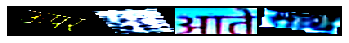

In [0]:
show_images(disp_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


('पर', 'बाहर', 'मत', 'जब')


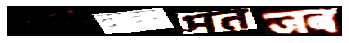

In [0]:
show_images(disp_loader)

### CRNN Model

In [0]:
import torch.nn as nn


class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        
        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)

        return output


In [0]:
def init_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            print("Linear layers initialized")
            xavier(m.weight)
        elif isinstance(m, nn.Conv2d):
            print("Linear layers initialized")
            xavier(m.weight)
        elif isinstance(m, nn.BatchNorm2d):
            print("BN layers initialized")
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            print("BN layers initialized")
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)
        else:
            pass

def xavier(parameters):
    init.kaiming_normal_(parameters,nonlinearity='leaky_relu')

In [0]:
vocab_size = len(hindi_alphabets_str) + 1 # extra character for blank symbol
weight_decay = 1e-5
clip_norm = 5
print(vocab_size)

129


In [0]:
crnn = CRNN(32,3,129, 256,2,True)

In [0]:
crnn

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): LeakyReLU(negative_slope=0.2, inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_s

In [0]:
parallel_net = DataParallel(crnn,device_ids=[0])

In [0]:
lr = 0.01
optimizer = torch.optim.Adadelta(parallel_net.parameters())
critertion = nn.CTCLoss(blank=0)

In [0]:
def validation(model, val_losses, label_converter):
    with torch.no_grad():
        model.eval()
        for batch_img, batch_text in dataloader["val"]:
            logits = crnn(batch_img.to(device))
            val_loss = calculate_loss(logits, batch_text, label_converter)
            val_losses.append(val_loss.item())
            del batch_img, batch_text
            torch.cuda.empty_cache()
    return val_losses,val_loss

In [0]:
def calculate_loss(logits, texts, label_converter):
    # get infomation from prediction
    device = logits.device
    input_len, batch_size, vocab_size = logits.size()
    # encode inputs
    logits = logits.log_softmax(2)
    encoded_texts, text_lens = label_converter.encode(texts)
    logits_lens = torch.full(size=(batch_size,), fill_value=input_len, dtype=torch.int32)
    # calculate ctc
    loss = critertion(logits, encoded_texts, 
                      logits_lens.to(device), text_lens)
    return loss

In [0]:
def train_model(model, dataloaders,optimizer, num_epochs=100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            print("{} Mode ............".format(phase.upper()))
            running_loss = 0.0
        
            # Iterate over data.
            for idx,(batch_imgs, batch_text) in enumerate(dataloaders[phase]):
                batch_imgs = batch_imgs.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):        
                    logits = model(batch_imgs)
                    train_loss = calculate_loss(logits, batch_text, label_converter)

                    if np.isnan(train_loss.detach().cpu().numpy()):
                      continue
                    
                  
                    # backward + optimize only if in training phase
                    if phase == 'train':
                      print("Batch {}/{} Train Loss:{:.3f}".format(idx+1,len(dataloaders[phase]),train_loss.item()))
                      train_loss.backward()
                      nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
                      optimizer.step()

                    del batch_imgs, batch_text
                    torch.cuda.empty_cache()

                # statistics
                running_loss += train_loss.item()


            epoch_loss = running_loss / len(dataloaders[phase])
        
            

            print('{} Epoch Loss: {:.4f}'.format(phase, epoch_loss))

          
           
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
best_model = train_model(crnn,dataloader,optimizer,num_epochs=50)

### Test Data

In [0]:
def get_filepaths_and_labels(annotation_path):
  with open(annotation_path,"r") as f:
    paths = []
    texts = []
    dataset = {}
    for line in f:
      path = line.split("\t")[0]
      text = line.split("\t")[1]
      path = os.path.join(os.path.dirname(annotation_path),path)
      dataset[path] = text
      paths.append(path)
      texts.append(text)
  return dataset,paths,texts

In [0]:
dataset,paths,texts = get_filepaths_and_labels("./drive/My Drive/Cropped_Validation_Images/annotations.txt")

In [0]:
test_df = pd.DataFrame(data = list(dataset.items()),columns=["File_Paths","text"])

In [0]:
test_df.head()

,File_Paths,text
0,./drive/My Drive/Cropped_Validation_Images/cro...,जल
1,./drive/My Drive/Cropped_Validation_Images/cro...,शोध
2,./drive/My Drive/Cropped_Validation_Images/cro...,न
3,./drive/My Drive/Cropped_Validation_Images/cro...,संयंत्र
4,./drive/My Drive/Cropped_Validation_Images/cro...,बिना


In [0]:
test_data = TextRecognitionDataset(test_df,mean=(0.3821, 0.3934, 0.4027), std=(0.1830, 0.1789, 0.1691), phase="test",train=False)

In [0]:
test_data[-1]

(tensor([[[ 0.3764,  0.0978,  0.1621,  ...,  0.9764,  1.3407,  0.8050],
          [ 0.1192,  0.1407,  0.2264,  ...,  1.4264,  0.4835,  0.6550],
          [-0.2022, -0.1165, -0.2665,  ...,  1.0193,  1.0621,  0.6335],
          ...,
          [ 0.2692,  0.3764,  0.2050,  ...,  0.5264,  0.4621,  0.5478],
          [ 0.2478,  0.5050,  0.6335,  ...,  0.3121,  0.3764,  0.5693],
          [-0.5451, -0.2451,  0.0550,  ...,  0.1835,  0.2478,  0.3121]],
 
         [[ 1.7686,  1.4836,  1.5494,  ...,  2.2728,  2.6454,  2.1193],
          [ 1.5056,  1.5275,  1.6152,  ...,  2.6673,  1.7248,  1.9001],
          [ 1.2206,  1.3083,  1.1329,  ...,  2.2509,  2.2947,  1.9001],
          ...,
          [ 1.5056,  1.5713,  1.4179,  ...,  1.6152,  1.6152,  1.7905],
          [ 1.4836,  1.7467,  1.8782,  ...,  1.5494,  1.5494,  1.7467],
          [ 0.7603,  1.0672,  1.3960,  ...,  1.4398,  1.4836,  1.5713]],
 
         [[ 2.7669,  2.4655,  2.5350,  ...,  3.0220,  3.4858,  3.0684],
          [ 2.4886,  2.5118,

In [0]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128,shuffle=False)

#### Loading Trained Model 1

###### Model Path : ./drive/My Drive/CRNN_model_weights/crnn_bigger_model_without_augments_adam_17.pth


In [0]:
PATH = "./drive/My Drive/CRNN_model_weights/crnn_bigger_model_without_augments_adam_17.pth"
parallel_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Truth: संदीप
Prediction: सदीप



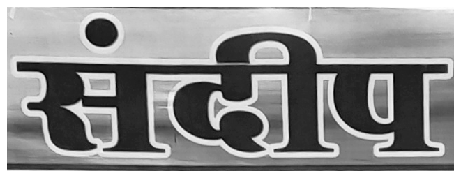

In [0]:
print_prediction(parallel_net,test_data, device, label_converter)

Truth: फोड़े
Prediction: फई



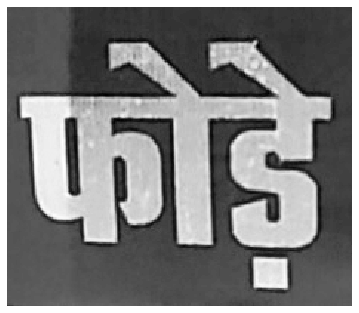

In [0]:
print_prediction(parallel_net,test_data, device, label_converter)

#### Loading Trained Model 2

###### Model PATH: ./drive/My Drive/CRNN_model_weights/crnn_bigger_model_50.pth

In [0]:
PATH = "./drive/My Drive/CRNN_model_weights/crnn_bigger_model_50.pth"
parallel_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Truth: बेचने
Prediction: बचने



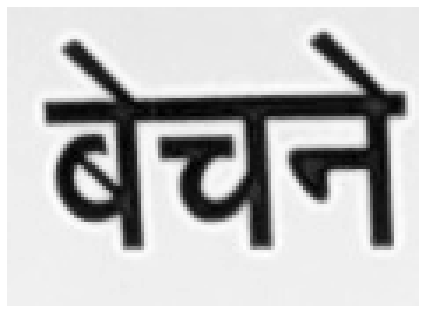

In [0]:
print_prediction(parallel_net,test_data, device, label_converter)